[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1tayKZyBpQX0nswLEjX6f7smUwvHii6D9?usp=sharing)

# Text classification - IMDB Dataset

In [1]:
from huggingface_hub import login
login('xxxx')


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /Users/amirkazemim/.cache/huggingface/token
Login successful


In [2]:
import numpy as np

## Datasets library

In [2]:
from datasets import load_dataset

imdb = load_dataset("imdb")
imdb

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [6]:
len(imdb['train']['text'])


25000

In [4]:
imdb['train'] = imdb['train'].shuffle(seed=1).select(range(2000))
imdb['train']

Dataset({
    features: ['text', 'label'],
    num_rows: 2000
})

In [5]:
imdb_train_validation = imdb['train'].train_test_split(train_size=0.8)
imdb_train_validation

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1600
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 400
    })
})

In [6]:
imdb_train_validation['test']

Dataset({
    features: ['text', 'label'],
    num_rows: 400
})

In [7]:
imdb_train_validation['validation'] = imdb_train_validation.pop('test')
imdb_train_validation

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1600
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 400
    })
})

In [8]:
imdb.update(imdb_train_validation)
imdb

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1600
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 400
    })
})

In [9]:
imdb['test'] = imdb['test'].shuffle(seed=1).select(range(400))
imdb['test']

Dataset({
    features: ['text', 'label'],
    num_rows: 400
})

In [10]:
type(imdb)

datasets.dataset_dict.DatasetDict

In [11]:
imdb.pop('unsupervised')
imdb

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1600
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 400
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 400
    })
})

## Create library

In [3]:
from datasets import Dataset
from datasets import DatasetDict
import pandas as pd


In [4]:
class create_dataset():
    def __init__(self, df, rs = 1):
        self.df = df
        self.rng = np.random.default_rng(seed=rs)

    def _get_df_spls(self, frcs):
        if np.sum(frcs) > 1:
            frcs = np.array(frcs) / np.sum(frcs)
        
        lendf = len(self.df)
        tot_frc = np.sum(frcs)
        n = int(lendf*tot_frc)
        n_spls = [int(lendf*frc) for frc in frcs]
        n_spls[-1] = n - np.sum(n_spls[:-1])
        i_spls = np.cumsum(n_spls)
        
        inds = self.rng.choice(np.arange(lendf), n, replace=False)
        sel_inds = np.split(inds, i_spls[:-1])
        # print(sel_inds)
        sel_msk = []
        for ind in sel_inds:
            msk = np.full(lendf, False)
            msk[ind] = True
            sel_msk.append(msk)
            
        return [self.df[ind] for ind in sel_msk]
    
    def get_train_val_test(self, frcs = [0.8, 0.1, 0.1]):
        if len(frcs) != 3:
            print(f'only using the first 3 fractions: {frcs[:3]}')

        df_dics = [f.to_dict('list') for f in self._get_df_spls(frcs[:3])]
        dtset = [Dataset.from_dict(dfd) for dfd in df_dics]
        return DatasetDict({k:v for k, v in zip(['train', 'test', 'validation'], dtset)})



In [169]:
df_csv = pd.read_csv('../scrape/test_food_bev_alc.csv')
unq_id = df_csv.typeID.unique()
print([fnc(unq_id) for fnc in [len, max]])
df_csv.drop(columns=['typeID', 'link'], inplace=True)
df_csv.rename(columns={"product": "text"}, inplace=True)
df_csv.head()

[2244, 2327]


,text,label
0,New Belgium Brewing Fat Tire Ale12 fl oz,alcohol/beer/ales/amber red ale
1,"Yuengling Beer, Traditional Lager, 24 Pack12 fl oz",alcohol/beer/ales/amber red ale
2,George Killian's Irish Red Lager Beer12 fl oz,alcohol/beer/ales/amber red ale
3,"Dragon's Milk Crimson Keep, Bourbon Barrel-Aged Red Ale, 11% ABV12 fl oz",alcohol/beer/ales/amber red ale
4,Smithwick's Red Ale Beer14.9 fl oz,alcohol/beer/ales/amber red ale


In [170]:
class create_number_labs():
    def __init__(self, labs, col) -> None:
        self.df = labs
        self._name_dict = create_number_labs.get_num_dic(self.df[col])
        self._num_dict = create_number_labs.get_depth(self._name_dict)
        self._depth = create_number_labs.get_max_depth(self._name_dict)
        self.label_array = np.array([self._gen_nums(x[col]) for _,x in self.df.iterrows()])
        self._max_level = np.max(self.label_array)
        self.base_rep = list(map(lambda x:create_number_labs.baseToNumber(x,self._max_level), self.label_array))
        for i in range(self._depth):
            self.df[f'lab_{i}'] = self.label_array[:,i]

        self.df['base_label'] = self.base_rep


    @staticmethod
    def baseToNumber(lst, b):
        lst = lst[::-1]
        n = 0
        for i, d in enumerate(lst):
            n += d*b**i
        return n


    def _gen_nums(self, lb):
        spl = lb.split('/')
        arr = np.full(self._depth, 0)
        dic = self._name_dict
        # arr[0] = create_number_labs._get_index(self._name_dict, spl[0])
        for i in range(len(spl)):
            arr[i] = create_number_labs._get_index(dic, spl[i])
            dic = dic[spl[i]]
        return arr

    @staticmethod
    def _lab_spl(lab, i):
        spls = lab.split('/')
        if len(spls) > i:
            return spls[i]
        else:
            return '-'

    @staticmethod    
    def _get_index(dic, lab):
        # print(list(dic.keys()), lab)
        return list(dic.keys()).index(lab)+1       
    
    @staticmethod
    def get_max_depth(dic):
        if len(dic) == 0:
            return 0
        else:
            return 1 + max([create_number_labs.get_max_depth(dic[v]) for v in dic.keys()])
        
    @staticmethod
    def get_depth(dic, level = 0):
        if len(dic) == 0:
            return {}
        else:
            return {i:create_number_labs.get_depth(dic[v], level+1) for i, v in enumerate(dic.keys())}

    @staticmethod
    def get_num_dic(labs):
        lab_ids = {}
        spl_lbs = [l.split('/') for l in labs]
        l0s = [l[0] for l in spl_lbs]
        lrs = ['/'.join(l[1:]) if len(l)>1 else '-' for l in spl_lbs]
        tempdf = pd.DataFrame({'lrs':lrs})
        lsels = sorted(list(set(l0s)))
        if '-' in lsels:
            lab_ids['-'] = 0
            lsels.remove('-')

        for i, lab in enumerate(lsels):
            lab_ids[lab] = i+1

        id_labs = np.array(list(map(lambda x:lab_ids[x], l0s)))

        for i, lab in enumerate(lsels):
            lab_ids[lab] = create_number_labs.get_num_dic(tempdf.loc[id_labs == i+1, 'lrs'])

        if '-' in list(lab_ids.keys()):
            return {}
        else:
            return lab_ids


    
def numberToBase(n, b):
    if n == 0:
        return [0]
    digits = []
    while n:
        digits.append(int(n % b))
        n //= b
    return digits[::-1]

def baseToNumber_norev(lst, b):
    n = 0
    for i, d in enumerate(lst):
        n += d*b**(len(lst)-i-1)
    return n




In [171]:
id_chk = create_number_labs(df_csv, 'label')

In [175]:
df_csv.head()


,text,label,lab_0,lab_1,lab_2,lab_3,lab_4,lab_5,base_label
0,New Belgium Brewing Fat Tire Ale12 fl oz,alcohol/beer/ales/amber red ale,1,2,1,1,0,0,1989043776
1,"Yuengling Beer, Traditional Lager, 24 Pack12 fl oz",alcohol/beer/ales/amber red ale,1,2,1,1,0,0,1989043776
2,George Killian's Irish Red Lager Beer12 fl oz,alcohol/beer/ales/amber red ale,1,2,1,1,0,0,1989043776
3,"Dragon's Milk Crimson Keep, Bourbon Barrel-Aged Red Ale, 11% ABV12 fl oz",alcohol/beer/ales/amber red ale,1,2,1,1,0,0,1989043776
4,Smithwick's Red Ale Beer14.9 fl oz,alcohol/beer/ales/amber red ale,1,2,1,1,0,0,1989043776


In [135]:
np.where(df_csv[[f'lab_{i}' for i in range(6)]] == 72)

(array([33761, 33762, 33763, 33764, 33765, 33766, 33767, 33768, 33769]),
 array([4, 4, 4, 4, 4, 4, 4, 4, 4]))

In [136]:
df_csv.iloc[33761]

text                                       Zestar Appleeach
label    food/fresh produce/fresh fruit/apples/zestar apple
lab_0                                                     3
lab_1                                                     4
lab_2                                                     1
lab_3                                                     1
lab_4                                                    72
lab_5                                                     0
Name: 33761, dtype: object

In [139]:
len(id_chk._name_dict['food']['fresh produce']['fresh fruit']['apples'])

72

In [194]:
dset = create_dataset(df_csv)
df_csv['orig_lab'] = df_csv['label'].copy()
df_csv['label'] = df_csv['base_label'].copy()
imdb = dset.get_train_val_test([.1,.05,.05])
# [len(ddfs['product']) for ddfs in dict_dfs]
# len(dict_dfs)

## Overview of IMDB Dataset

In [195]:
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('max_colwidth', 250)

In [196]:
imdb.set_format('pandas')
df = imdb['train'][:]
df.sample(frac=1 ,random_state=1).head(10)

,text,label,lab_0,lab_1,lab_2,lab_3,lab_4,lab_5,base_label,orig_lab
5207,"RiceSelect White Rice, Jasmati32 oz",6022781640,3,8,8,10,1,0,6022781640,food/pantry/grains/rices/basmati rice
2785,Ducks1 lb,5968251504,3,6,6,3,6,0,5968251504,food/meat/poultry/duck/half duck
2304,8 S Untrimmed Choice Beef Loin Tri Tip Roastper lb,5966432640,3,6,1,12,16,0,5966432640,food/meat/beef/beef roast/tri tip roast
420,"DOW’S Porto, Fine Tawny750 ml",2070437760,1,5,3,6,0,0,2070437760,alcohol/wine/dessert wine/port
1614,Table Talk Eclair Pie Chocolate4 oz,5832072864,3,1,1,14,4,0,5832072864,food/baked goods/bakery desserts/pies/chocolate pie
1604,"First Street Cherry Pie, Lattice Top24 oz",5832072792,3,1,1,14,3,0,5832072792,food/baked goods/bakery desserts/pies/cherry pie
1225,Hormel Gatherings Chicken Ham & Cheese Party Tray28 oz,5886499392,3,3,3,1,0,0,5886499392,food/deli/prepared meals/deli party trays
2711,ROCKY Fresh Chicken Drumsticks1.53 lb,5968241208,3,6,6,1,7,0,5968241208,food/meat/poultry/chicken/chicken drumstick
5916,"Signature SELECT Kidney Beans, Dark Red15 oz",6021242208,3,8,4,1,4,0,6021242208,food/pantry/canned goods/canned beans/canned kidney beans
714,Imagery Estate Winery Pinot Noir Red Wine750 ml,2071738944,1,5,6,41,0,0,2071738944,alcohol/wine/red wine/pinot noir


In [197]:
df.loc[0, 'text']

"Mac & Jack's Brewing Co. Marty Time Lager12 fl oz"

In [198]:
df['text'] = df.text.str.replace('<br />', '')
df.loc[0, 'text']

"Mac & Jack's Brewing Co. Marty Time Lager12 fl oz"

In [199]:
df.base_label.value_counts()

base_label
6020159112    13
6020205480    11
6020199936    11
5862632256    11
5913083520    11
              ..
5967126144     1
5967141696     1
6047390088     1
6047390160     1
5966432208     1
Name: count, Length: 1933, dtype: int64

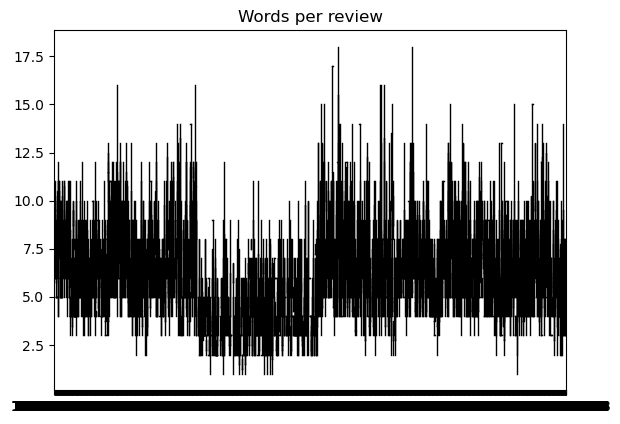

In [200]:
df["Words per review"] = df["text"].str.split().apply(len)
df.boxplot("Words per review", by="base_label", grid=False, showfliers=False,
           color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [201]:
# 0 is negative
# 1 is positive
df[df.text.str.len() < 200]

,text,label,lab_0,lab_1,lab_2,lab_3,lab_4,lab_5,base_label,orig_lab,Words per review
0,Mac & Jack's Brewing Co. Marty Time Lager12 fl oz,1989043776,1,2,1,1,0,0,1989043776,alcohol/beer/ales/amber red ale,10
1,"Pizza Port Brewing Co. Amber Ale, Chronicale16.9 fl oz",1989043776,1,2,1,1,0,0,1989043776,alcohol/beer/ales/amber red ale,9
2,"Global Beer Network Beer, Gulden Draak11.2 fl oz",1989043776,1,2,1,1,0,0,1989043776,alcohol/beer/ales/amber red ale,8
3,Full Sail Amber Ale12 fl oz,1989043776,1,2,1,1,0,0,1989043776,alcohol/beer/ales/amber red ale,6
4,"Weyerbacher Ale, Blithering Idiot, Barley-Wine Style12 fl oz",1989054144,1,2,1,3,0,0,1989054144,alcohol/beer/ales/barley wine,8
...,...,...,...,...,...,...,...,...,...,...,...
7589,Aneto 100% Natural Fish Broth33.8 fl oz,6026094432,3,8,17,1,4,0,6026094432,food/pantry/soups/broths stocks/other broths,7
7590,Culinary Tours Ramen Broth32 fl oz,6026094432,3,8,17,1,4,0,6026094432,food/pantry/soups/broths stocks/other broths,6
7591,"Manischewitz Whitefish & Pike, Sweet, Jelled Broth24 oz",6026094432,3,8,17,1,4,0,6026094432,food/pantry/soups/broths stocks/other broths,8
7592,Zatarain's Shrimp Creole Base2 oz,6026094432,3,8,17,1,4,0,6026094432,food/pantry/soups/broths stocks/other broths,5


In [202]:
imdb.reset_format()

## Tokenizer

In [203]:
from transformers import AutoTokenizer

checkpoint = "distilbert-base-cased"
#checkpoint = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

imdb_encoded = imdb.map(tokenize_function, batched=True, batch_size=None)
imdb_encoded

Map:   0%|          | 0/7594 [00:00<?, ? examples/s]

Map:   0%|          | 0/3797 [00:00<?, ? examples/s]

Map:   0%|          | 0/3797 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'lab_0', 'lab_1', 'lab_2', 'lab_3', 'lab_4', 'lab_5', 'base_label', 'orig_lab', 'input_ids', 'attention_mask'],
        num_rows: 7594
    })
    test: Dataset({
        features: ['text', 'label', 'lab_0', 'lab_1', 'lab_2', 'lab_3', 'lab_4', 'lab_5', 'base_label', 'orig_lab', 'input_ids', 'attention_mask'],
        num_rows: 3797
    })
    validation: Dataset({
        features: ['text', 'label', 'lab_0', 'lab_1', 'lab_2', 'lab_3', 'lab_4', 'lab_5', 'base_label', 'orig_lab', 'input_ids', 'attention_mask'],
        num_rows: 3797
    })
})

In [204]:
print(imdb_encoded['train'][0])

{'text': "Mac & Jack's Brewing Co. Marty Time Lager12 fl oz", 'label': 1989043776, 'lab_0': 1, 'lab_1': 2, 'lab_2': 1, 'lab_3': 1, 'lab_4': 0, 'lab_5': 0, 'base_label': 1989043776, 'orig_lab': 'alcohol/beer/ales/amber red ale', 'input_ids': [101, 6603, 111, 2132, 112, 188, 139, 11899, 1158, 3291, 119, 12768, 2614, 2001, 2895, 11964, 22593, 24919, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}


## Tiny IMDB

In [205]:
import transformers
import re

[x for x in dir(transformers) if re.search(r'^AutoModel', x)]

['AutoModel',
 'AutoModelForAudioClassification',
 'AutoModelForAudioFrameClassification',
 'AutoModelForAudioXVector',
 'AutoModelForCTC',
 'AutoModelForCausalLM',
 'AutoModelForDepthEstimation',
 'AutoModelForDocumentQuestionAnswering',
 'AutoModelForImageClassification',
 'AutoModelForImageSegmentation',
 'AutoModelForImageToImage',
 'AutoModelForInstanceSegmentation',
 'AutoModelForKeypointDetection',
 'AutoModelForMaskGeneration',
 'AutoModelForMaskedImageModeling',
 'AutoModelForMaskedLM',
 'AutoModelForMultipleChoice',
 'AutoModelForNextSentencePrediction',
 'AutoModelForObjectDetection',
 'AutoModelForPreTraining',
 'AutoModelForQuestionAnswering',
 'AutoModelForSemanticSegmentation',
 'AutoModelForSeq2SeqLM',
 'AutoModelForSequenceClassification',
 'AutoModelForSpeechSeq2Seq',
 'AutoModelForTableQuestionAnswering',
 'AutoModelForTextEncoding',
 'AutoModelForTextToSpectrogram',
 'AutoModelForTextToWaveform',
 'AutoModelForTokenClassification',
 'AutoModelForUniversalSegmentatio

In [206]:
import torch
from transformers import AutoModelForSequenceClassification

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_mps = torch.backends.mps.is_available()
device = torch.device("mps" if use_mps else "cpu")

num_labels = 2
model = (AutoModelForSequenceClassification
         .from_pretrained(checkpoint, num_labels=num_labels)
         .to(device))

In [207]:
from datasets import DatasetDict

tiny_imdb = DatasetDict()
tiny_imdb['train'] = imdb['train'].shuffle(seed=1).select(range(50))
tiny_imdb['validation'] = imdb['validation'].shuffle(seed=1).select(range(10))
tiny_imdb['test'] = imdb['test'].shuffle(seed=1).select(range(10))

tiny_imdb_encoded = tiny_imdb.map(tokenize_function, batched=True, batch_size=None)
tiny_imdb_encoded

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'lab_0', 'lab_1', 'lab_2', 'lab_3', 'lab_4', 'lab_5', 'base_label', 'orig_lab', 'input_ids', 'attention_mask'],
        num_rows: 50
    })
    validation: Dataset({
        features: ['text', 'label', 'lab_0', 'lab_1', 'lab_2', 'lab_3', 'lab_4', 'lab_5', 'base_label', 'orig_lab', 'input_ids', 'attention_mask'],
        num_rows: 10
    })
    test: Dataset({
        features: ['text', 'label', 'lab_0', 'lab_1', 'lab_2', 'lab_3', 'lab_4', 'lab_5', 'base_label', 'orig_lab', 'input_ids', 'attention_mask'],
        num_rows: 10
    })
})

In [208]:
from transformers import Trainer, TrainingArguments

batch_size = 8
logging_steps = len(tiny_imdb_encoded["train"]) // batch_size
model_name = f"{checkpoint}-finetuned-tiny-prod"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  log_level="error",
                                  optim='adamw_torch'
                                  )
training_args

/Applications/conda/miniconda3/envs/test_burnt/lib/python3.9/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_steps=None,
eval_strategy=epoch,
evaluation_strategy=epoch,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsd

In [209]:
from transformers import Trainer

torch.cuda.empty_cache()

trainer = Trainer(model=model,
                  args=training_args,
                  train_dataset=tiny_imdb_encoded["train"],
                  eval_dataset=tiny_imdb_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train();

  0%|          | 0/14 [00:00<?, ?it/s]

{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 1.1428571428571429e-05, 'epoch': 0.86}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.0, 'eval_runtime': 0.2128, 'eval_samples_per_second': 46.989, 'eval_steps_per_second': 9.398, 'epoch': 1.0}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 2.8571428571428573e-06, 'epoch': 1.71}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.0, 'eval_runtime': 0.032, 'eval_samples_per_second': 312.03, 'eval_steps_per_second': 62.406, 'epoch': 2.0}
{'train_runtime': 4.0582, 'train_samples_per_second': 24.641, 'train_steps_per_second': 3.45, 'train_loss': 0.0, 'epoch': 2.0}


In [210]:
preds = trainer.predict(tiny_imdb_encoded['test'])
preds

  0%|          | 0/2 [00:00<?, ?it/s]

PredictionOutput(predictions=array([[ 0.05856271, -0.05703023],
       [ 0.08528452, -0.06278823],
       [ 0.0841004 , -0.05779456],
       [ 0.07487205, -0.0700006 ],
       [ 0.06368414, -0.06828137],
       [ 0.07952752, -0.05441577],
       [ 0.04123146, -0.08017737],
       [ 0.06266971, -0.06756914],
       [ 0.05481916, -0.08479203],
       [ 0.03525893, -0.09207605]], dtype=float32), label_ids=array([6021721080, 5940273024, 2071619712, 2072780928, 6022766016,
       2072739456, 5966426520, 2070059328, 5913146520, 5966421120]), metrics={'test_loss': 0.0, 'test_runtime': 0.6079, 'test_samples_per_second': 16.45, 'test_steps_per_second': 3.29})

In [211]:
preds.predictions.shape

(10, 2)

In [212]:
preds.predictions.argmax(axis=-1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [213]:
preds.label_ids

array([6021721080, 5940273024, 2071619712, 2072780928, 6022766016,
       2072739456, 5966426520, 2070059328, 5913146520, 5966421120])

In [214]:
from sklearn.metrics import accuracy_score

accuracy_score(preds.label_ids, preds.predictions.argmax(axis=-1))

0.0

In [215]:
def get_accuracy(preds):
  predictions = preds.predictions.argmax(axis=-1)
  labels = preds.label_ids
  accuracy = accuracy_score(preds.label_ids, preds.predictions.argmax(axis=-1))
  return {'accuracy': accuracy}


In [216]:
from transformers import Trainer

torch.cuda.empty_cache()

trainer = Trainer(model=model,
                  compute_metrics=get_accuracy,
                  args=training_args,
                  train_dataset=tiny_imdb_encoded["train"],
                  eval_dataset=tiny_imdb_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train();

  0%|          | 0/14 [00:00<?, ?it/s]

{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 1.1428571428571429e-05, 'epoch': 0.86}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.0, 'eval_accuracy': 0.0, 'eval_runtime': 0.0554, 'eval_samples_per_second': 180.652, 'eval_steps_per_second': 36.13, 'epoch': 1.0}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 2.8571428571428573e-06, 'epoch': 1.71}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.0, 'eval_accuracy': 0.0, 'eval_runtime': 0.04, 'eval_samples_per_second': 250.027, 'eval_steps_per_second': 50.005, 'epoch': 2.0}
{'train_runtime': 2.0401, 'train_samples_per_second': 49.018, 'train_steps_per_second': 6.863, 'train_loss': 0.0, 'epoch': 2.0}


## Training run

In [217]:
batch_size = 8
logging_steps = len(imdb_encoded["train"]) // batch_size
model_name = f"{checkpoint}-finetuned-products"
# model_name = f"{checkpoint}-finetuned-tiny-imdb"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  log_level="error",
                                  optim='adamw_torch'
                                  )

/Applications/conda/miniconda3/envs/test_burnt/lib/python3.9/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [218]:
from transformers import Trainer

torch.cuda.empty_cache()

trainer = Trainer(model=model,
                  args=training_args,
                  compute_metrics=get_accuracy,
                  train_dataset=imdb_encoded["train"],
                  eval_dataset=imdb_encoded["validation"],
                  tokenizer=tokenizer)
# trainer = Trainer(model=model,
#                   args=training_args,
#                   compute_metrics=get_accuracy,
#                   train_dataset=tiny_imdb_encoded["train"],
#                   eval_dataset=tiny_imdb_encoded["validation"],
#                   tokenizer=tokenizer)


trainer.train();

  0%|          | 0/1900 [00:00<?, ?it/s]

{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 1.0010526315789474e-05, 'epoch': 1.0}


  0%|          | 0/475 [00:00<?, ?it/s]

{'eval_loss': 0.0, 'eval_accuracy': 0.0, 'eval_runtime': 17.4964, 'eval_samples_per_second': 217.016, 'eval_steps_per_second': 27.148, 'epoch': 1.0}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 2.1052631578947368e-08, 'epoch': 2.0}


  0%|          | 0/475 [00:00<?, ?it/s]

{'eval_loss': 0.0, 'eval_accuracy': 0.0, 'eval_runtime': 12.1582, 'eval_samples_per_second': 312.301, 'eval_steps_per_second': 39.068, 'epoch': 2.0}
{'train_runtime': 248.3212, 'train_samples_per_second': 61.163, 'train_steps_per_second': 7.651, 'train_loss': 0.0, 'epoch': 2.0}


In [219]:


trainer.evaluate()

  0%|          | 0/475 [00:00<?, ?it/s]

{'eval_loss': 0.0,
 'eval_accuracy': 0.0,
 'eval_runtime': 12.623,
 'eval_samples_per_second': 300.801,
 'eval_steps_per_second': 37.63,
 'epoch': 2.0}

In [220]:
trainer.save_model()

In [221]:
model_name

'distilbert-base-cased-finetuned-products'

In [222]:
from transformers import pipeline
classifier = pipeline('text-classification', model=model_name)
# classifier = pipeline('text-classification', model=model)
classifier('This is not my idea of fun')

[{'label': 'LABEL_0', 'score': 0.5465585589408875}]

In [55]:
classifier('This was beyond incredible')

[{'label': 'LABEL_1', 'score': 0.6042473912239075}]